## Добрый день, дорогие друзья!

Этот ноутбук является приложением к статье **Алгоритмы рекомендательных систем** на портале **NTA**.  

В исследовании указаны основные подходы к поиску схожих объектов в наборе данных и содержатся основные идеи работы рекомендательных систем. Есть примеры подготовки данных.  
Информация будет полезна аналитикам, которые изучают возможности python, и начинающим data-scientist’ам.   

Разделы кода соответствуют главам в тексте. 

In [1]:
# импортируем необходимые библиотеки
import numpy as np
import pandas as pd
import torch
import re
import torch
from tqdm import notebook
from itertools import combinations
from transformers import AutoTokenizer, AutoModel

from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import cdist, cosine
from scipy.stats.stats import pearsonr

from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.pyplot as plt

2021-09-13 12:49:02.003164: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2021-09-13 12:49:02.003291: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
BERT = '../input/deeppavlov-rubertbasecased'

### Корреляции

In [3]:
# загружаем датасет, выбираем столбцы с количественными значениями и сохраняем первые 10 строк
df = pd.read_csv('../input/housedata/data.csv')

df = df[['bedrooms','bathrooms','sqft_living','sqft_lot',
        'floors','waterfront','view','sqft_above','sqft_basement','yr_built','yr_renovated']]

df_10 = df[:10]
df_10

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,sqft_above,sqft_basement,yr_built,yr_renovated
0,3.0,1.50,1340,7912,1.5,0,0,1340,0,1955,2005
1,5.0,2.50,3650,9050,2.0,0,4,3370,280,1921,0
2,3.0,2.00,1930,11947,1.0,0,0,1930,0,1966,0
3,3.0,2.25,2000,8030,1.0,0,0,1000,1000,1963,0
4,4.0,2.50,1940,10500,1.0,0,0,1140,800,1976,1992
5,2.0,1.00,880,6380,1.0,0,0,880,0,1938,1994
6,2.0,2.00,1350,2560,1.0,0,0,1350,0,1976,0
7,4.0,2.50,2710,35868,2.0,0,0,2710,0,1989,0
8,3.0,2.50,2430,88426,1.0,0,0,1570,860,1985,0
9,4.0,2.00,1520,6200,1.5,0,0,1520,0,1945,2010


In [4]:
# коэфиициент корреляции Пирсона в Pandas
df_10.loc[0].corr(df.loc[9]), df_10.loc[0].corr(df.loc[6])

(0.9927509742092635, 0.8027668015655981)

In [5]:
# коэфиициент корреляции Спирмена и (тау) Кенделла
df_10.loc[0].corr(df_10.loc[9], method='spearman'), df_10.loc[0].corr(df_10.loc[6], method='kendall')

(0.9976717081331427, 0.7013664474559794)

In [6]:
# коэфиициент корреляции Пирсона в Scipy
pearsonr(df_10.loc[0], df_10.loc[9])

(0.992750974209264, 1.3619436280417694e-09)

In [7]:
# коэфиициент корреляции Пирсона в Numpy
np.corrcoef(df_10.loc[0], df_10.loc[9])

array([[1.        , 0.99275097],
       [0.99275097, 1.        ]])

In [8]:
# так выглядит транспонированная таблица. Строки становятся столбцами, а столбцы строками.
df_10.T

,0,1,2,3,4,5,6,7,8,9
bedrooms,3.0,5.0,3.0,3.00,4.0,2.0,2.0,4.0,3.0,4.0
bathrooms,1.5,2.5,2.0,2.25,2.5,1.0,2.0,2.5,2.5,2.0
sqft_living,1340.0,3650.0,1930.0,2000.00,1940.0,880.0,1350.0,2710.0,2430.0,1520.0
sqft_lot,7912.0,9050.0,11947.0,8030.00,10500.0,6380.0,2560.0,35868.0,88426.0,6200.0
floors,1.5,2.0,1.0,1.00,1.0,1.0,1.0,2.0,1.0,1.5
waterfront,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0
view,0.0,4.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0
sqft_above,1340.0,3370.0,1930.0,1000.00,1140.0,880.0,1350.0,2710.0,1570.0,1520.0
sqft_basement,0.0,280.0,0.0,1000.00,800.0,0.0,0.0,0.0,860.0,0.0
yr_built,1955.0,1921.0,1966.0,1963.00,1976.0,1938.0,1976.0,1989.0,1985.0,1945.0


In [9]:
# создание матрицы корреляции Пирсона с цветовой идентификацией
df_10.T.corr().style.background_gradient(cmap='YlOrBr')

,0,1,2,3,4,5,6,7,8,9
0,1.000000,0.915276,0.965829,0.950184,0.990555,0.995375,0.802767,0.953282,0.940758,0.992751
1,0.915276,1.000000,0.957996,0.953866,0.920452,0.877755,0.893200,0.914591,0.881888,0.917656
2,0.965829,0.957996,1.000000,0.985751,0.977221,0.942069,0.817916,0.988925,0.975470,0.942078
3,0.950184,0.953866,0.985751,1.000000,0.973512,0.928585,0.838883,0.967273,0.953426,0.929472
4,0.990555,0.920452,0.977221,0.973512,1.000000,0.980265,0.774953,0.973712,0.965971,0.972951
5,0.995375,0.877755,0.942069,0.928585,0.980265,1.000000,0.787830,0.930378,0.920422,0.990011
6,0.802767,0.893200,0.817916,0.838883,0.774953,0.787830,1.000000,0.724498,0.676273,0.836433
7,0.953282,0.914591,0.988925,0.967273,0.973712,0.930378,0.724498,1.000000,0.997042,0.915408
8,0.940758,0.881888,0.975470,0.953426,0.965971,0.920422,0.676273,0.997042,1.000000,0.895736
9,0.992751,0.917656,0.942078,0.929472,0.972951,0.990011,0.836433,0.915408,0.895736,1.000000


Создание простейшего рекомендательного алгоритма.  
Два примера - подробный, но долгий против краткого и быстрого.

In [10]:
# код будет подбирать 10 наиболее похожих объектов из имеющегося списка

# выбираем случайный образцовый объект недвижимости и выводим информацию о нем
idx = np.random.randint(0,4600)
# при первой итерации ноутбука выпал индекс 574. Он сохранен для воспроизводимости результатов статьи.
idx = 574
obj = df.loc[idx]

print(obj)

bedrooms            2.0
bathrooms           1.0
sqft_living       910.0
sqft_lot         6232.0
floors              1.0
waterfront          0.0
view                0.0
sqft_above        910.0
sqft_basement       0.0
yr_built         1943.0
yr_renovated     2002.0
Name: 574, dtype: float64


In [11]:
%%time
# примем порог значения корреляции для попадания в финальный результат равным 0.995
THRES = 0.995

# ответ рекомендательной системы будем выводить сразу в датафрейм
# чтобы не прописывать создание фрема с нуля - создадим его из имеющейся таблицы
df_recommend = df.head(0).copy()

# пробегаемся циклом по всем объектам в продаже, кроме образцового
for row in df.index:
    # высчитываем коэффициент корреляции между двумя объектами
    corr = obj.corr(df.loc[row])
    # если коэффициент больше или равен значению порога - добавляем запись в новую таблицу вместе с коэффициентом
    if corr >= THRES: 
        df_recommend = pd.concat([df_recommend, df.query('index == @row')])
        df_recommend.loc[row, 'corr_coef'] = corr

# сортируем результат по значению коэффициента и выводим десятку лучших + первая строка образцовая
df_recommend.sort_values(by='corr_coef', ascending=False, inplace=True)
df_recommend = df_recommend.head(11)

df_recommend

CPU times: user 2.66 s, sys: 18.4 ms, total: 2.68 s
Wall time: 2.68 s


,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,sqft_above,sqft_basement,yr_built,yr_renovated,corr_coef
574,2.0,1.0,910,6232,1.0,0,0,910,0,1943,2002,1.000000
821,2.0,1.0,870,6150,1.0,0,0,870,0,1941,1994,0.999965
4249,2.0,1.0,930,6380,1.0,0,0,930,0,1940,2001,0.999950
42,2.0,1.0,850,6174,1.0,0,0,850,0,1950,1983,0.999923
755,2.0,1.0,880,6345,1.0,0,0,880,0,1919,2001,0.999920
5,2.0,1.0,880,6380,1.0,0,0,880,0,1938,1994,0.999907
4525,2.0,1.0,880,6413,1.0,0,0,880,0,1950,2005,0.999900
3741,2.0,1.0,860,6050,1.0,0,0,860,0,1952,2008,0.999873
1403,2.0,1.0,910,6490,1.0,0,0,910,0,1942,1999,0.999855
814,2.0,1.0,830,6017,1.0,0,0,830,0,1954,1979,0.999812


In [12]:
%%time
# более "питонистый", короткий и быстрый для выполнения путь. 
# создаем матрицу корреляции для всей таблицы, выбираем столбец со значениями корреляции для образца.
# сортируем коэффициенты по убыванию и выбираем первые десять значений. Первая запись равна единице - это строка образца.
# сохраняем индексы лучших совпадений и выбираем эти строки из общей таблицы.
obj = df.loc[574]
corrs = df.T.corr()[idx].sort_values(ascending=False)[:11].rename('corrs')
df_res = df.query('index in @corrs.index')

# присоединяем значения расчитанных коэффициентов к результатам и сортируем их в порядке убывания
df_res = df_res.join(corrs)
df_res.sort_values('corrs', ascending=False)

CPU times: user 692 ms, sys: 45.2 ms, total: 737 ms
Wall time: 742 ms


,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,sqft_above,sqft_basement,yr_built,yr_renovated,corrs
574,2.0,1.0,910,6232,1.0,0,0,910,0,1943,2002,1.000000
821,2.0,1.0,870,6150,1.0,0,0,870,0,1941,1994,0.999965
4249,2.0,1.0,930,6380,1.0,0,0,930,0,1940,2001,0.999950
42,2.0,1.0,850,6174,1.0,0,0,850,0,1950,1983,0.999923
755,2.0,1.0,880,6345,1.0,0,0,880,0,1919,2001,0.999920
5,2.0,1.0,880,6380,1.0,0,0,880,0,1938,1994,0.999907
4525,2.0,1.0,880,6413,1.0,0,0,880,0,1950,2005,0.999900
3741,2.0,1.0,860,6050,1.0,0,0,860,0,1952,2008,0.999873
1403,2.0,1.0,910,6490,1.0,0,0,910,0,1942,1999,0.999855
814,2.0,1.0,830,6017,1.0,0,0,830,0,1954,1979,0.999812


In [13]:
# метод pandas.corr() работает с пропущенными значениями. можно работать без предобработки
x = pd.Series([1,2,3,4,5])
y = pd.Series([np.nan, np.nan,5,6,6])

x.corr(y)

0.8660254037844385

### Косинусное расстояние

In [14]:
# для исследования возьмем тысячу заголовков новостей с порталов lenta.ru и ria.ru
df_news = pd.read_csv('../input/russian-news-2020/news.csv', encoding='utf8')[['title', 'rubric']][:1000]
df_news.head()

,title,rubric
0,Синий богатырь,Экономика
1,Загитова согласилась вести «Ледниковый период»,Спорт
2,Объяснена опасность однообразного питания,Из жизни
3,«Предохраняться? А зачем?»,Интернет и СМИ
4,Ефремов систематически употреблял наркотики,Культура


In [15]:
# загружаем два алгоритма
# токенайзер - инструмент перевода слов в токены - числовые значения слов в словаре 
# и модель превращения вектора с токенами в эмбеддинги

tokenizer = AutoTokenizer.from_pretrained(BERT)
model = AutoModel.from_pretrained(BERT)

Нужно ли удалять стоп-слова из названий новостей?  
Если вопрос ставит вас в тупик, ознакомтесь с [этой статьей](https://medium.com/@bigdataschool/%D0%BF%D1%80%D0%B5%D0%B4%D0%BE%D0%B1%D1%80%D0%B0%D0%B1%D0%BE%D1%82%D0%BA%D0%B0-%D1%82%D0%B5%D0%BA%D1%81%D1%82%D0%B0-%D0%B2-nlp-82c164bb7416). По опыту решения подобных задач отметим, что очистка текста обычно меняется от задачи к задаче.  

In [16]:
# переносим названия статей из колонки датафрейма в список и приводим все слова в нижний регистр
corpus = df_news['title'].str.lower().values

# удаляем из текста ненужные знаки препинания
corpus_new = []
for text in corpus:
    text = re.sub(r'\xa0', ' ', text)
    text = re.sub(r'«»,:', '', text)
    corpus_new.append(text)

# переводим предложения в векторы
# каждому слову соответсвует определеное число в словаре
tokenized = []
for i in corpus_new:
    tokenized.append(tokenizer.encode(i, add_special_tokens=True))

# рассчитываем максимальную длину маски внимания
max_len = 0
for i in tokenized:
    if len(i) > max_len:
        max_len = len(i)

# для каждого токенизированного предложения создаем маску внимания и приводим векторы к единой длине
padded = np.array([i + [0]*(max_len - len(i)) for i in tokenized])
attention_mask = np.where(padded != 0, 1, 0)

# сколько предложений будет обработано за одну итерацию
batch_size = 1

# c помощью модели BERT переводим токенизированные предложения в эмбеддинги
embeddings = []
for i in notebook.tqdm(range(padded.shape[0] // batch_size)):
        batch = torch.LongTensor(padded[batch_size * i : batch_size * (i + 1)]) 
        attention_mask_batch = torch.LongTensor(attention_mask[batch_size * i : batch_size * (i + 1)])
        
        with torch.no_grad():
            batch_embeddings = model(batch, attention_mask=attention_mask_batch)
        
        embeddings.append(batch_embeddings[0][:,0,:].numpy())

  0%|          | 0/1000 [00:00<?, ?it/s]

In [17]:
df_news.loc[10]

title     В суде по делу MH17 прокурор потребовала компе...
rubric                                                  Мир
Name: 10, dtype: object

In [18]:
corpus_new = []
for text in corpus:
    text = re.sub(r'\xa0', ' ', text)
    corpus_new.append(text)

In [19]:
# так выглядит исходное предложение
corpus_new[18]

'рынок европы начал рекордно восстанавливаться'

In [20]:
# так выглядит предложение в токенизированном виде
tokenized[18]

[101, 18912, 60836, 880, 4051, 76481, 101355, 102]

In [21]:
# так выглядят первые 10 значений эмбеддинга этого предложения
embeddings[10][0][:10]

array([-0.29139647,  0.10100818, -0.05670362,  0.05141545,  0.29009324,
        0.1498651 , -0.25141326, -0.04086271, -0.12941946,  0.21187256],
      dtype=float32)

In [22]:
# Пример сравнения двух векторизированных заголовков
print(df_news.loc[17, 'title'])
print(df_news.loc[420, 'title'])

from sklearn.metrics.pairwise import cosine_similarity
cosine_similarity(embeddings[419], embeddings[420])

Samsung выпустила смартфон с рекордной батареей
«Ювентус» уволил главного тренера после вылета из Лиги чемпионов


array([[0.23828188]], dtype=float32)

In [23]:
# выбираем пример, относительно которого будем подбирать похожие новости
example = embeddings[18]

# два списка, в которые будем отбирать претендетов на показ
idx = []
cos_sim = []

# пробегаемся списком по всем эмбеддингам и выбираем те, где косинусное расстояние от образца менее 15%. 
# или где косинусная схожесть больше или равна 85%
for i, j in enumerate(embeddings):
    if cosine_similarity(example, j) >= 0.85:
        idx.append(i)
        cos_sim.append(cosine_similarity(example, j)[0][0])

# собираем все найденные заголовки в новый датафрейм, добавляем конисусное расстояние и выводим топ-11 подобных заголовков
# заголовок со схожестью 1 - образец
cos_sim = pd.Series(cos_sim, name='cos_sim', index=idx)
res = df_news.query('index in @idx').copy()
res = res.join(cos_sim)

res = res.sort_values(by='cos_sim', ascending=False)[:11]

res

,title,rubric,cos_sim
18,Рынок Европы начал рекордно восстанавливаться,Экономика,1.000000
849,Россиян предупредили о росте цен,Экономика,0.983593
866,Россия и Белоруссия договорились по нефти,Экономика,0.983389
983,Гонконг «отрежут» от доллара,Экономика,0.983291
566,Названа самая пострадавшая от кризиса страна Е...,Экономика,0.983287
762,В Сочи закончились места для туристов,Путешествия,0.983187
850,Мировой кризис сыграл на руку итальянскому мин...,Экономика,0.982979
75,На Западе посчитали рубль слишком дешевым,Экономика,0.982790
796,Министр здравоохранения Украины признал отсутс...,Бывший СССР,0.982006
233,Россияне скупили «золотые паспорта» в Греции,Дом,0.981731


### Кластеризация

In [24]:
# Для задачи кластеризации отберем 300 домов
df_300 = df[:300]
df_300.head()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,sqft_above,sqft_basement,yr_built,yr_renovated
0,3.0,1.50,1340,7912,1.5,0,0,1340,0,1955,2005
1,5.0,2.50,3650,9050,2.0,0,4,3370,280,1921,0
2,3.0,2.00,1930,11947,1.0,0,0,1930,0,1966,0
3,3.0,2.25,2000,8030,1.0,0,0,1000,1000,1963,0
4,4.0,2.50,1940,10500,1.0,0,0,1140,800,1976,1992


In [25]:
# рассчитаем оптимальное количество кластеров в диапазоне от 1 до 20
distortion = []
K = range(1, 20) 
# последовательно рассчитываем значения целевой функции по всем объектам
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_300)
    distortion.append(kmeans.inertia_) 

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


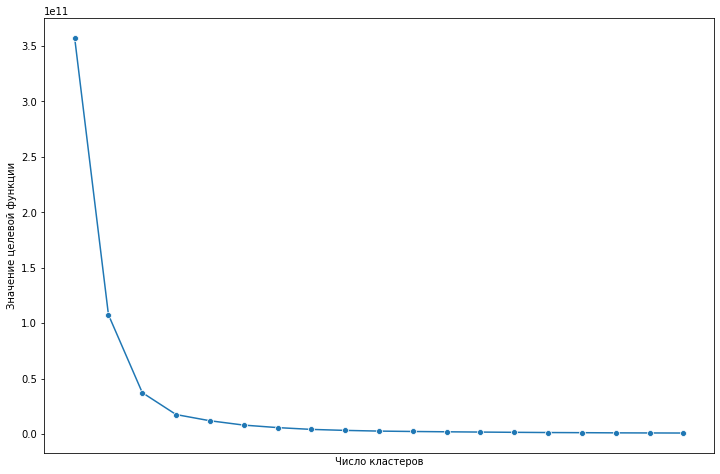

In [26]:
# строим график изменения целевой функции в зависимости от количества кластеров
# оптимальное число находится в месте, где график максимально "ломается". В нашем примере - это 4.
plt.figure(figsize=(12, 8))
sns.lineplot(
    data=distortion,
    marker="o")

plt.xlabel('Число кластеров')
plt.tick_params(
    axis='x',          
    bottom=False, labelbottom=False)
plt.ylabel('Значение целевой функции');

In [27]:
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(df_300)

df_300['label'] = kmeans.labels_

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [28]:
df_300['label'] = kmeans.labels_

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [29]:
df_300['label'].value_counts()

0    267
3     22
1      8
2      3
Name: label, dtype: int64

In [30]:
df_300.query('label == 1').head(10)

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,sqft_above,sqft_basement,yr_built,yr_renovated,label
8,3.0,2.50,2430,88426,1.0,0,0,1570,860,1985,0,1
56,4.0,1.75,2190,125452,1.0,0,2,2190,0,1968,1997,1
107,4.0,2.50,4340,141570,2.5,0,0,4340,0,1992,0,1
170,6.0,3.00,3470,117612,1.5,0,0,3470,0,1924,2011,1
233,4.0,4.00,4460,103382,2.0,0,0,4460,0,2001,0,1
254,3.0,1.75,2720,149410,1.5,0,0,2720,0,1988,2000,1
262,3.0,2.50,3240,108366,2.0,0,0,3240,0,1991,0,1
263,3.0,2.50,2460,108900,1.0,0,0,1860,600,1977,0,1


In [31]:
df_300.query('label == 2').head(10)

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,sqft_above,sqft_basement,yr_built,yr_renovated,label
122,7.0,8.00,13540,307752,3.0,0,4,9410,4130,1999,0,2
240,3.0,2.50,2680,327135,2.0,0,0,2680,0,1995,0,2
272,5.0,3.75,4130,226076,2.0,0,0,3170,960,1985,0,2
